Script to produce grid plot of errors for reaction coordinate + solvation sampling:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

Plot Grid Plots:

Base Model:  GO-MACE-23
Base Model Energy Error:  20.3
Base Model Force Error:  831.0
Energy Grid Rows: 
 [[17.4 21.6 17.6 18.9]
 [13.8 13.8 14.1 15. ]
 [14.2 12.5 13.7 14.1]
 [12.7 12.  13.4 12.7]
 [12.1 11.7 14.1 13.5]]
Force Grid Rows: 
 [[317. 352. 299. 324.]
 [128. 110. 111. 113.]
 [129. 106. 107. 105.]
 [122. 108. 109. 107.]
 [135. 113. 116. 111.]]


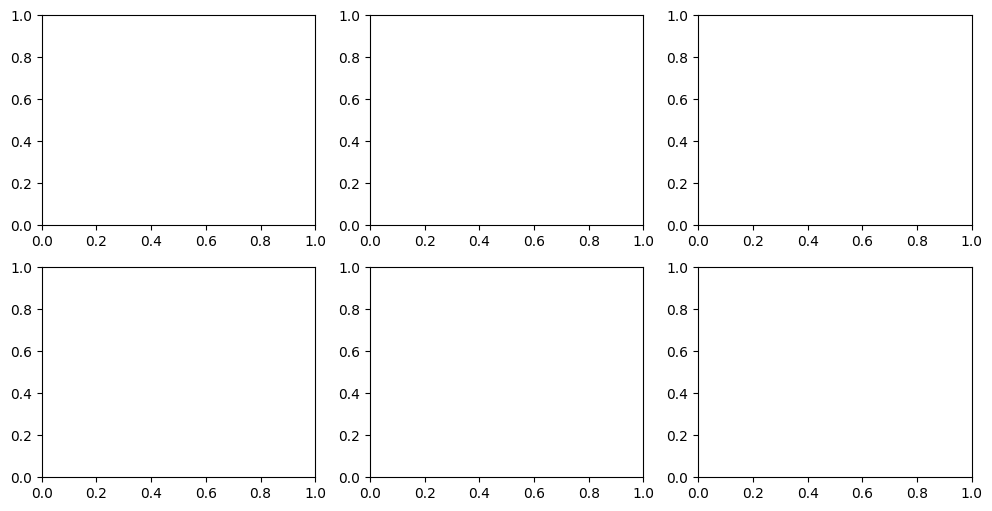

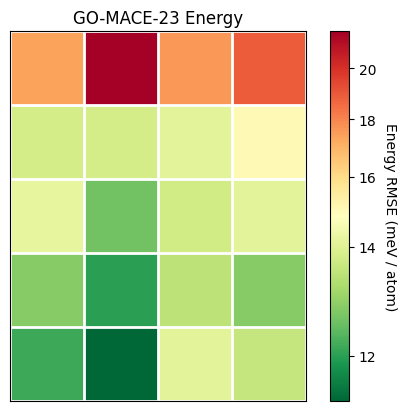

Saved plot to out/plt/grid/GO-MACE-23_endo_DA_combined_Energy_react_solv_grid.png


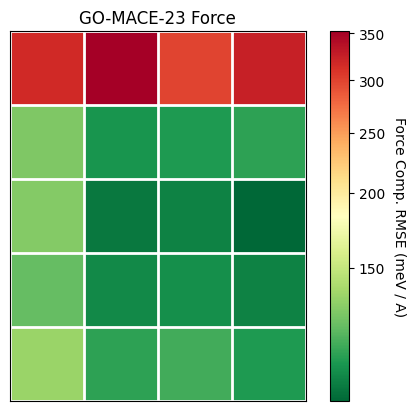

Saved plot to out/plt/grid/GO-MACE-23_endo_DA_combined_Force_react_solv_grid.png
Base Model:  MACE-OFF23_medium
Base Model Energy Error:  18.3
Base Model Force Error:  166.0
Energy Grid Rows: 
 [[ 9.43 10.5  11.8  11.6 ]
 [ 8.24  9.57 10.    9.95]
 [ 8.59  8.02  8.14 10.8 ]
 [ 8.77 10.5   7.94 10.9 ]
 [10.9  10.9   9.9  11.6 ]]
Force Grid Rows: 
 [[124.   97.  103.   98.2]
 [114.   82.4  86.6  87.6]
 [112.   85.4  86.7  90.2]
 [107.   90.3  87.1  91.4]
 [114.  101.   95.5  95.6]]


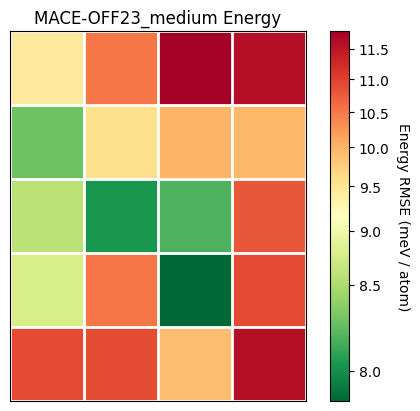

Saved plot to out/plt/grid/MACE-OFF23_medium_endo_DA_combined_Energy_react_solv_grid.png


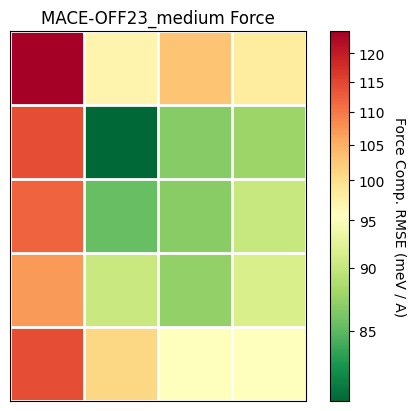

Saved plot to out/plt/grid/MACE-OFF23_medium_endo_DA_combined_Force_react_solv_grid.png
Base Model:  MACE-MP0-128-L1
Base Model Energy Error:  17.1
Base Model Force Error:  429.0
Energy Grid Rows: 
 [[24.3 18.6 20.7 24.6]
 [24.2 14.2 16.1 17.9]
 [25.6 19.4 16.  15.6]
 [27.4 21.8 12.9 14. ]
 [21.8 17.7 16.4 17.9]]
Force Grid Rows: 
 [[671. 693. 657. 628.]
 [202. 151. 178. 172.]
 [206. 150. 158. 153.]
 [242. 163. 165. 178.]
 [233. 181. 189. 194.]]


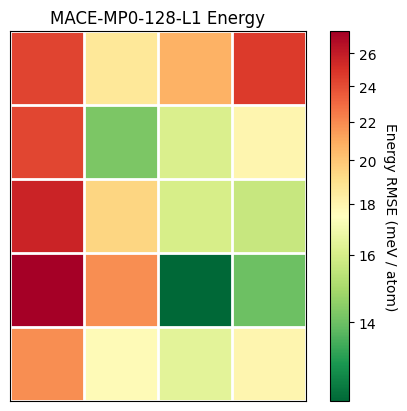

Saved plot to out/plt/grid/MACE-MP0-128-L1_endo_DA_combined_Energy_react_solv_grid.png


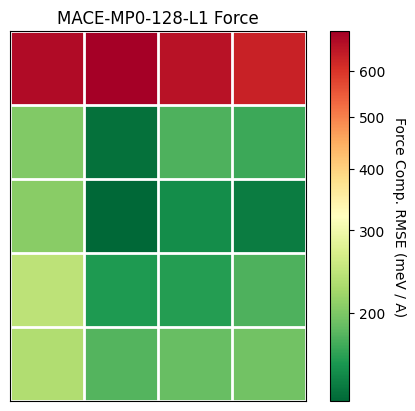

Saved plot to out/plt/grid/MACE-MP0-128-L1_endo_DA_combined_Force_react_solv_grid.png


In [36]:
from matplotlib.colors import PowerNorm, TwoSlopeNorm

# SELECT MODELS:
model_names = ["GO-MACE-23", "MACE-OFF23_medium", "MACE-MP0-128-L1"]
# fig_combined, axes = plt.subplots(2, 3, figsize=(12, 6))
all_model_energy_errors, all_model_force_errors = [], []
for model_name in model_names:

    # SELECT INPUT CSV FILE:
    # 1. combined vacuum + react in water test set
    input_csv_file = f"test_set_comparison_endo_DA_final_test_combined_{model_name}_endo_DA_n=8_r_dist_fine_tuned.csv"
    save_name = 'endo_DA_combined'
    col_name = 'Endo DA Combined Test'

    # 2. just react in water test set
    # input_csv_file = f"test_set_comparison_endo_DA_final_test_combined_react_in_water_{model_name}_endo_DA_n=8_r_dist_fine_tuned.csv"
    # save_name = 'endo_DA_combined_react_in_water'
    # col_name = 'Endo DA Combined Test React in Water'
    # ===========================

    df = pd.read_csv(input_csv_file)

    # get base model 
    base_model_energy_error, base_model_force_error = df.iloc[0][f"{col_name} Energies (meV / atom)"], df.iloc[0][f"{col_name} Forces (meV / A)"]
    df = df.iloc[1:]  # remove base model row
    print("Base Model: ", model_name)
    print("Base Model Energy Error: ", base_model_energy_error)
    print("Base Model Force Error: ", base_model_force_error)

    # group by solv frac
    df.sort_values(['Model'])
    # df['r_dist'] = df['Model'].str.extract(r'r_dist_(\d+_\d+)')
    df['solv'] = df['Model'].str.extract(r'solv_(\d+)').astype('int32')
    grouped = df.groupby('solv')

    # get relative energy / force improvement
    energy_grid_rows, force_grid_rows = [], []
    for solv, group in grouped:
        energy_grid_rows.append(np.array(group[f"{col_name} Energies (meV / atom)"]))
        force_grid_rows.append(np.array(group[f"{col_name} Forces (meV / A)"]))

    energy_grid_rows, force_grid_rows = np.array(energy_grid_rows), np.array(force_grid_rows)
    print('Energy Grid Rows: \n', energy_grid_rows)
    print('Force Grid Rows: \n', force_grid_rows)
    all_model_energy_errors.append(energy_grid_rows)
    all_model_force_errors.append(force_grid_rows)

    use_log_scale = False
    label_set = ['Energy RMSE (meV / atom)', 'Force Comp. RMSE (meV / A)']
    type_set = ['Energy', 'Force']
    # y_ranges = [(-15, 15), (-730.0, 730.0)]
    y_ranges = [(None, None), (None, None)]
    grid_rows_set = [energy_grid_rows, force_grid_rows]
    for grid_rows, label, type, y_range in zip(grid_rows_set, label_set, type_set, y_ranges):

        # normalise the data between -1.0 and 1.0
        # min_val = np.min(grid_rows)
        # max_val = np.max(grid_rows)
        # grid_rows = 2 * (grid_rows - min_val) / (max_val - min_val) - 1.0
        # print('Grid Rows Norm: \n', grid_rows)

        if use_log_scale:
            grid_rows = np.log(grid_rows)

        # Create the plot
        fig, ax = plt.subplots()
        norm = PowerNorm(gamma=0.6, vmin=y_range[0], vmax=y_range[1])
        # norm = TwoSlopeNorm(vmin=-1.0, vcenter=0, vmax=1)
        # im = ax.imshow(grid_rows, cmap='viridis_r', aspect='equal')
        im = ax.imshow(grid_rows, cmap='RdYlGn_r', aspect='equal', norm=norm)

        # Add a colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(label, rotation=270, labelpad=15)  # Customize label and padding

        # Optional: add grid lines
        ax.set_xticks(np.arange(grid_rows.shape[1]+1) - 0.5, minor=True)
        ax.set_yticks(np.arange(grid_rows.shape[0]+1) - 0.5, minor=True)
        ax.grid(which="minor", color="white", linestyle='-', linewidth=2)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Optional: remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{model_name} {type}')
        save_fp = f"{model_name}_{save_name}_{type}_react_solv_grid.png"
        plt.savefig(save_fp, format='png', dpi=600)

        plt.show()
        print(f'Saved plot to {save_fp}')